## Vocabulary Size를 변경해서 시도해보기
- 지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다.그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일이 한정되지 않을 수 있습니다.
- 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.중요도가 낮은 단어들까지 포함해서 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다.그리고 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.
- 단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅시다.앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 로 처리하는 원리였었죠.
- 아래의 두 가지 경우에 대해서 지금까지 사용했던 모델들의 정확도를 직접 확인해 보세요. 1) 모든 단어 사용 2) 빈도수 상위 5,000개의 단어만 사용 기타) 직접 단어 갯수를 설정해서 사용

- 참고사이트 : https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/3-5-%EB%89%B4%EC%8A%A4-%EA%B8%B0%EC%82%AC-%EB%B6%84%EB%A5%98-%EB%8B%A4%EC%A4%91-%EB%B6%84%EB%A5%98-%EB%AC%B8%EC%A0%9C/

In [1]:
# 모든 프로젝트에 해당되는 패키지를 먼저 임포트
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 1. 모든 단어 사용 

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


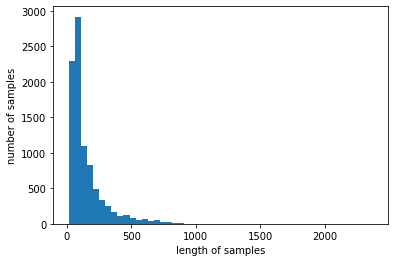

In [3]:
# 데이터 분포 파악
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 1만개였을 때와 큰 차이 없음

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

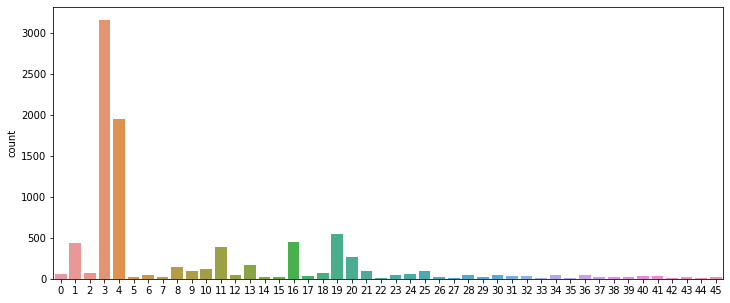

In [4]:
# 타겟데이터 파악
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [5]:
# 텍스트데이터로 복원
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 인덱스 +3
index_to_word = {index + 3 : word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

557056/550378 [==============================] - 0s 0us/step


In [6]:
# 전체 학습데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [7]:
# 전체 테스트데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [8]:
# DTM 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

# 테스트데이터
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환

(8982, 26506)


In [9]:
# TF-IDF Matrix확인
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

# 테스트데이터
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

(8982, 26506)


## 모델별 정확도 예측 (모든단어사용)

In [10]:
# 결과값 비교를 위한 리스트 선언
classifier_list = ["MultinomialNB", "ComplementNB", "Logistic Regression", "LinearSVC", "Decision Tree", "Random Forest", "GradientBoostingClassifier", "Voting"]
classifier_answer_list = []

In [11]:
# 나이브 베이즈 분류기
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.5997328584149599


In [12]:
# Complement Naive Bayes Classifier(CNB)
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7649154051647373


In [13]:
# 로지스틱 회귀(Logistic Regression)
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.813446126447017


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
# 선형 서포트 벡터 머신
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7876224398931434


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [15]:
# 결정 트리(Decision Tree)
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6211041852181657


In [16]:
# 랜덤 포레스트(Random Forest)
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6544968833481746


In [17]:
# 그래디언트 부스팅 트리(GradientBoostingClassifier) 
#오래걸림 
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7702582368655387


In [18]:
# 보팅(Voting)
# 로지스틱 회귀, CNB, 그래디언트 부스팅 트리 세 가지를 사용
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.8187889581478184


In [19]:
# 모델별 정확도 정리 
print("빈도수 제한없을 때 정확도 리스트")
print()
for x in range(len(classifier_list)):
    print(classifier_list[x], ":", classifier_answer_list[x].round(2))

빈도수 제한없을 때 정확도 리스트

MultinomialNB : 0.6
ComplementNB : 0.76
Logistic Regression : 0.81
LinearSVC : 0.79
Decision Tree : 0.62
Random Forest : 0.65
GradientBoostingClassifier : 0.77
Voting : 0.82


## 2. 빈도수 상위5000개 단어 사용
- 빈도수 상위 X개(10000 등) 단어 사용도 아래 코드를 이용해서 결과정리함. 

In [55]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


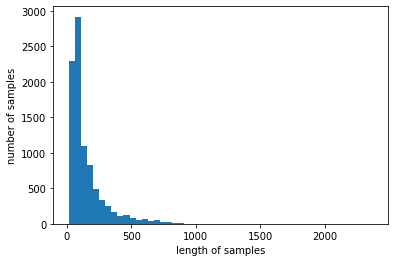

In [56]:
# 데이터 분포 파악
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

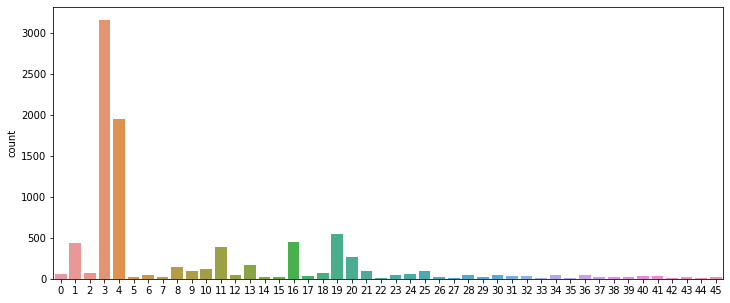

In [57]:
# 타겟데이터 파악
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [58]:
# 텍스트데이터로 복원
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 인덱스 +3
index_to_word = {index + 3 : word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [59]:
# 전체 학습데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [60]:
# 전체 테스트데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [61]:
# DTM 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

# 테스트데이터
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환

(8982, 9670)


In [62]:
# TF-IDF Matrix확인
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

# 테스트데이터
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

(8982, 9670)


In [63]:
# 결과값 비교를 위한 리스트 선언
classifier_list = ["MultinomialNB", "ComplementNB", "Logistic Regression", "LinearSVC", "Decision Tree", "Random Forest", "GradientBoostingClassifier", "Voting"]
classifier_answer_list = []

## 모델별 정확도 예측 (5000단어사용)

In [64]:
# 나이브 베이즈 분류기
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6567230632235085


In [65]:
# Complement Naive Bayes Classifier(CNB)
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7707034728406055


In [66]:
# 로지스틱 회귀(Logistic Regression)
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.8076580587711487


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [67]:
# 선형 서포트 벡터 머신
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7751558325912734


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [68]:
# 결정 트리(Decision Tree)
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.6202137132680321


In [69]:
# 랜덤 포레스트(Random Forest)
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.674087266251113


In [70]:
# 그래디언트 부스팅 트리(GradientBoostingClassifier) 
#오래걸림 
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.7666963490650045


In [71]:
# 보팅(Voting)
# 로지스틱 회귀, CNB, 그래디언트 부스팅 트리 세 가지를 사용
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
classifier_answer_list.append(accuracy_score(y_test, predicted))

정확도: 0.8116651825467498


In [73]:
# 모델별 정확도 정리 
print("10000단어 정확도 리스트")
print()
for x in range(len(classifier_list)):
    print(classifier_list[x], ":", classifier_answer_list[x].round(2))

10000단어 정확도 리스트

MultinomialNB : 0.66
ComplementNB : 0.77
Logistic Regression : 0.81
LinearSVC : 0.78
Decision Tree : 0.62
Random Forest : 0.67
GradientBoostingClassifier : 0.77
Voting : 0.81


## 3. 딥러닝 모델과 비교

In [38]:
import numpy as np
from keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt

In [39]:
# 데이터 로드
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [40]:
print(train_data.shape, train_labels.shape)

(8982,) (8982,)


In [41]:
print(test_data.shape, test_labels.shape)

(2246,) (2246,)


In [42]:
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print(x_train.shape, x_test.shape)

(8982, 10000) (2246, 10000)


In [43]:
# 원핫인코딩을 해줍시다
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [44]:
from keras import models
from keras import layers

# 모델 생성
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # 클래스가 46개

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 모델 컴파일 설정
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# 데이터 나누기
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [48]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 40ms/step - loss: 3.6259 - accuracy: 0.2750 - val_loss: 2.7490 - val_accuracy: 0.5710
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 2.4222 - accuracy: 0.5777 - val_loss: 1.7013 - val_accuracy: 0.6260
Epoch 3/20
16/16 [==============================] - 0s 11ms/step - loss: 1.5011 - accuracy: 0.6770 - val_loss: 1.3347 - val_accuracy: 0.6870
Epoch 4/20
16/16 [==============================] - 0s 12ms/step - loss: 1.1400 - accuracy: 0.7520 - val_loss: 1.1766 - val_accuracy: 0.7390
Epoch 5/20
16/16 [==============================] - 0s 11ms/step - loss: 0.8792 - accuracy: 0.8064 - val_loss: 1.0763 - val_accuracy: 0.7710
Epoch 6/20
16/16 [==============================] - 0s 11ms/step - loss: 0.6918 - accuracy: 0.8456 - val_loss: 1.0063 - val_accuracy: 0.7980
Epoch 7/20
16/16 [==============================] - 0s 12ms/step - loss: 0.5794 - accuracy: 0.8761 - val_loss: 0.9699 - val_accuracy: 0.8040
Epoch 8/20
16

In [49]:
# 모델 평가
model.evaluate(x_test, one_hot_test_labels)

71/71 [==============================] - 0s 2ms/step - loss: 1.1274 - accuracy: 0.7872


[1.1274374723434448, 0.7871772050857544]

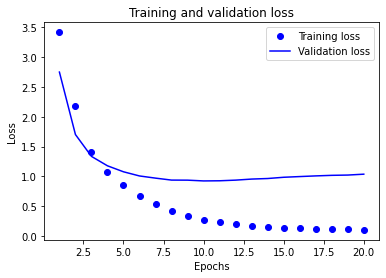

In [50]:
# 시각화
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [51]:
# epoch10이상에 overfitting되고 있기에 다시 훈련시킴. 
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=10,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
results

Epoch 1/10
16/16 [==============================] - 1s 22ms/step - loss: 3.5800 - accuracy: 0.3293 - val_loss: 2.6061 - val_accuracy: 0.5660
Epoch 2/10
16/16 [==============================] - 0s 11ms/step - loss: 2.3034 - accuracy: 0.5886 - val_loss: 1.7260 - val_accuracy: 0.6360
Epoch 3/10
16/16 [==============================] - 0s 11ms/step - loss: 1.5667 - accuracy: 0.6807 - val_loss: 1.3971 - val_accuracy: 0.6940
Epoch 4/10
16/16 [==============================] - 0s 12ms/step - loss: 1.1939 - accuracy: 0.7466 - val_loss: 1.2256 - val_accuracy: 0.7350
Epoch 5/10
16/16 [==============================] - 0s 12ms/step - loss: 0.9951 - accuracy: 0.7887 - val_loss: 1.1025 - val_accuracy: 0.7640
Epoch 6/10
16/16 [==============================] - 0s 12ms/step - loss: 0.7651 - accuracy: 0.8344 - val_loss: 1.0144 - val_accuracy: 0.7850
Epoch 7/10
16/16 [==============================] - 0s 11ms/step - loss: 0.5929 - accuracy: 0.8774 - val_loss: 0.9618 - val_accuracy: 0.8070
Epoch 8/10
16

[0.986325740814209, 0.7920747995376587]

In [53]:
# model중간layer가 class수보다 낮은 차원으로 내려가는 경우, 
# -> 정보 손실로 인한 결과예측이 나빠질 수 있음
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=10,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
results

Epoch 1/10
16/16 [==============================] - 1s 22ms/step - loss: 3.7393 - accuracy: 0.0615 - val_loss: 3.4255 - val_accuracy: 0.2160
Epoch 2/10
16/16 [==============================] - 0s 11ms/step - loss: 3.2978 - accuracy: 0.2383 - val_loss: 2.9159 - val_accuracy: 0.2630
Epoch 3/10
16/16 [==============================] - 0s 12ms/step - loss: 2.7300 - accuracy: 0.2919 - val_loss: 2.3197 - val_accuracy: 0.5470
Epoch 4/10
16/16 [==============================] - 0s 11ms/step - loss: 2.1140 - accuracy: 0.5813 - val_loss: 1.7953 - val_accuracy: 0.6140
Epoch 5/10
16/16 [==============================] - 0s 12ms/step - loss: 1.5304 - accuracy: 0.6586 - val_loss: 1.5004 - val_accuracy: 0.6540
Epoch 6/10
16/16 [==============================] - 0s 11ms/step - loss: 1.3000 - accuracy: 0.7012 - val_loss: 1.3602 - val_accuracy: 0.6850
Epoch 7/10
16/16 [==============================] - 0s 12ms/step - loss: 1.0884 - accuracy: 0.7339 - val_loss: 1.2685 - val_accuracy: 0.7180
Epoch 8/10
16

[1.1999962329864502, 0.7270703315734863]

## 프로젝트 정리 
1) 단어수에 따른 모델의 정확도 비교 
- 단어수가 많다고 좋은 정확도를 보이는 것은 아닌 것 같다. 5000단어를 사용했을 때 가장 정확도가 높았던 것 같음. 모델계산시 많은 단어수가 오히려 예측 정확도를 낮추는 요인으로 작용한 것 같음. 

2) 딥러닝모델과 비교 
- 나이브베이즈계열, Tree계열 모델 등 보다는 나은 결과를 냈음.(79%) 하지만, 로지스틱리그레션과 LinearSVC와 Voting보다는 낮은 예측 성과를 나타냈음. 


3) 딥러닝 model 중간layer가 class수 보다 낮은 차원으로 내려가는 경우, 분류의 정확도 하락.
- 특정 layer가 분류 문제에 필요한 일부 정보를 잃어버리면(저차원으로 정보압축시 정보손실발생), 그 다음 층에서 이를 복원할 방법이 없습니다. 
- 16차원을 가진 중간층을 사용함으로서(기존64층사용) 46개의 클래스를 구분하는데에 정보손실이 발생한 것으로 보임. 정확도가 낮아진 것으로 확인할 수 있음. 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있음. 
- 16차원 정확도: 76.05%, 8차원 정확도: 72.7% vs 64차원 정확도: 79.2%

## 결과 요약 
### 단어수제한 없음 
MultinomialNB : 0.6
ComplementNB : 0.76
Logistic Regression : 0.81
LinearSVC : 0.79
Decision Tree : 0.62
Random Forest : 0.65
GradientBoostingClassifier : 0.77
Voting : 0.82
### 단어수10000
MultinomialNB : 0.66
ComplementNB : 0.77
Logistic Regression : 0.81
LinearSVC : 0.78
Decision Tree : 0.62
Random Forest : 0.67
GradientBoostingClassifier : 0.77
Voting : 0.81
### 단어수 5000
MultinomialNB : 0.67
ComplementNB : 0.77
Logistic Regression : 0.81
LinearSVC : 0.77
Decision Tree : 0.62
Random Forest : 0.7
GradientBoostingClassifier : 0.77
Voting : 0.82